In [11]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Extend path to access local modules
sys.path.append("scripts")

from encode_dna import (
    read_fasta, filter_short_sequences,
    encode_kmer_batch, one_hot_encode, save_numpy_array,
    kmer_encoding
)

# ✅ Try to load GenBank-labeled sequences if available

In [12]:
try:
    filtered = np.load("data/processed/X_filtered.npy", allow_pickle=True)
    print("✅ Using labeled gene sequences from GenBank:", len(filtered))
except FileNotFoundError:
    print("⚠ Labeled GenBank data not found. Falling back to FASTA preprocessing.")
    potential_paths = [
        "../data/raw/azadirachta_indica.fasta",
        "data/raw/azadirachta_indica.fasta",
        "./data/raw/azadirachta_indica.fasta"
    ]
    fasta_path = None
    for path in potential_paths:
        if os.path.exists(path):
            fasta_path = path
            print(f"Found FASTA file at: {path}")
            break
    if not fasta_path:
        raise FileNotFoundError("❌ FASTA file not found in any of the expected locations.")

    sequences = read_fasta(fasta_path)
    filtered = filter_short_sequences(sequences, min_length=30)
    print(f"Total sequences: {len(sequences)} → Filtered: {len(filtered)}")

✅ Using labeled gene sequences from GenBank: 131


# 🧪 K-mer Encoding

In [13]:
X_kmer, kmer_vocab = encode_kmer_batch(filtered, k=3)
print(f"K-mer encoded shape: {X_kmer.shape}")
save_numpy_array(X_kmer, "data/processed/X_kmer.npy")

K-mer encoded shape: (131, 64)


# 🔢 One-hot Encoding (optional – for CNNs)

In [14]:
sequence_lengths = [len(seq) for seq in filtered]
median_length = int(np.median(sequence_lengths))

uniform_sequences = [
    seq[:median_length] if len(seq) > median_length else seq.ljust(median_length, 'N')
    for seq in filtered
]

X_onehot = one_hot_encode(uniform_sequences)
np.save("data/processed/X_onehot.npy", X_onehot)
print("✅ One-hot shape:", X_onehot.shape)

✅ One-hot shape: (131, 402, 5)


# 📊 Visualizations

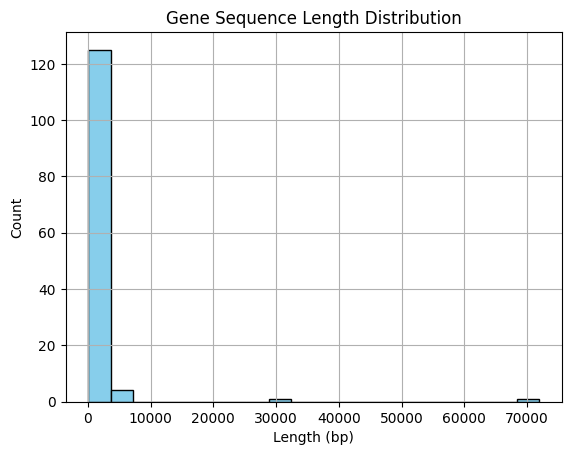

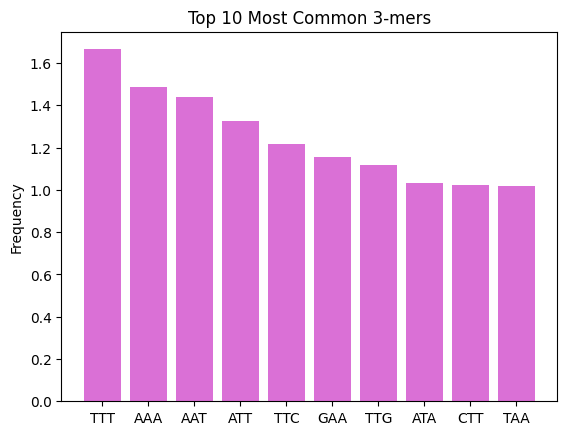

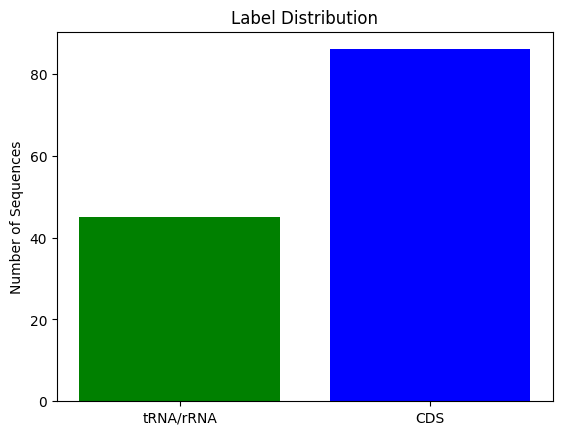

🎉 Preprocessing complete.


In [15]:
# 1. Sequence Length Distribution
lengths = [len(seq) for seq in filtered]
plt.hist(lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Gene Sequence Length Distribution")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 2. K-mer Frequency (Top 10)
merged = Counter()
for seq in filtered[:50]:  # limit to 50 for speed
    merged.update(kmer_encoding(seq, k=3))

top_10 = merged.most_common(10)
labels, values = zip(*top_10)
plt.bar(labels, values, color='orchid')
plt.title("Top 10 Most Common 3-mers")
plt.ylabel("Frequency")
plt.show()

# 3. Label Distribution (if available)
try:
    y = np.load("data/processed/y_labels.npy")
    label_counts = Counter(y)
    plt.bar(["tRNA/rRNA", "CDS"], [label_counts[0], label_counts[1]], color=["green", "blue"])
    plt.title("Label Distribution")
    plt.ylabel("Number of Sequences")
    plt.show()
except:
    print("ℹ️ Label file not found. Skipping label distribution plot.")

print("🎉 Preprocessing complete.")